In [2]:
from os.path import join
import subprocess

from itertools import product
from tqdm import tqdm
import yaml
from addict import Dict
import psutil
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
REPO_ROOT = subprocess.check_output("git rev-parse --show-toplevel".split()).decode().strip()
CONFIG_ROOT = join(REPO_ROOT, "config")

DATA_CONFIG = Dict(yaml.load(open(join(CONFIG_ROOT, "data.yaml"), "r"), Loader=yaml.FullLoader))

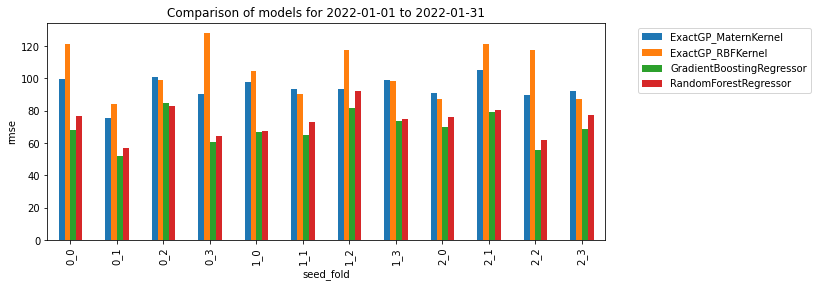

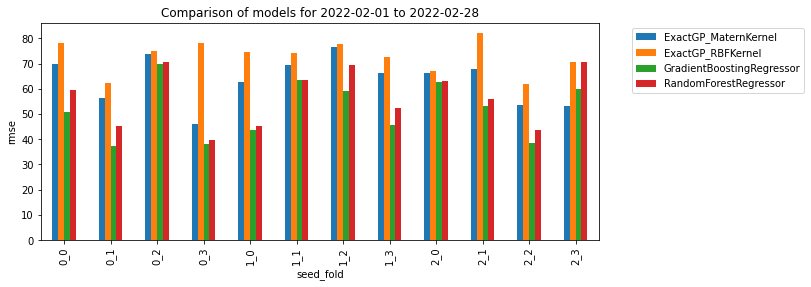

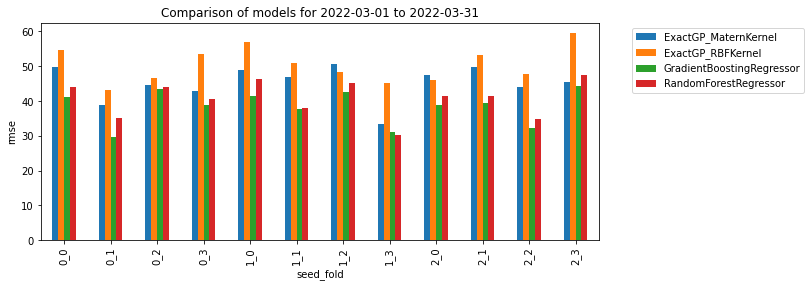

In [15]:
dates = [("2022-01-01", "2022-01-31"), ("2022-02-01", "2022-02-28"), ("2022-03-01", "2022-03-31")]
models = ["RandomForestRegressor", "GradientBoostingRegressor", "ExactGP_RBFKernel", "ExactGP_MaternKernel"]
metric = "rmse"

for start_date, end_date in dates:
    results = []
    exp_path = join(DATA_CONFIG.artifacts_path, join("_".join(sorted(DATA_CONFIG.features) + [start_date, end_date])))
    for model in models:
        result_df = pd.read_csv(join(exp_path, f"metrics_{model}.csv"))
        result_df["model"] = model
        results.append(result_df)
    
    results = pd.concat(results)
    results["seed_fold"] = results["seed"].astype(str) + "_" + results["fold"].astype(str)

    # plot comparison of models where x-axis is seed_fold and y-axis is rmse
    fig, ax = plt.subplots(figsize=(10, 4))
    results.groupby(["seed_fold", "model"])[metric].mean().unstack().plot(kind="bar", ax=ax)
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_ylabel(metric)
    ax.set_title(f"Comparison of models for {start_date} to {end_date}")